In [1]:
import numpy as np
import scipy.stats as sps
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
from matplotlib import path

import warnings
warnings.filterwarnings("ignore")
                        
seed = 42

In [2]:
class Inequations():
    def __init__(self, figures = None, N = None):
        self.colors = self.define_colors()
        self.inequations = []
        
        if figures is not None:
            self.figures = figures
        else:
            if N is not None:
                self.N = N
            else:
                self.N = 5
            self.centers = self.generate_centers(self.N)
            self.figures = np.array([self.generate_figures(self.centers[i], i) for i in range(len(self.centers))])
            
        f, ax = self.visualize_obstacles(with_centers = False)
        f.show()
        
        
        
    def __call__(self):
        """
        returns constraints function in the form of lambda g(x) which is <= 0 in the permitted area
        """
        testing_points = np.zeros((len(self.figures), 2))
        testing_colors = []
        
        for i, fig in enumerate(self.figures):
            inequations = self.get_figure_inequations(fig)
            self.inequations.append(inequations)
        
        self.plot_obstacles_with_inequations()
        self.constraints = self.get_constraints()
        self.test_constraints() #self.test_constraints(testing_points, testing_colors)
        return self.constraints
        
        
        
    def get_constraints(self):
        """
        obtains the constraints function from the sets of inequations for each figure
        """
        #return lambda x, y: np.max([np.min([coef[0] * x + coef[1] * y + coef[2] for coef in ineq_set]) 
        #                            for ineq_set in self.inequations])
        return lambda x: np.max([np.min([coef[0] * x[0] + coef[1] * x[1] + coef[2] for coef in ineq_set]) 
                                    for ineq_set in self.inequations])
            
    def get_constraint(self, ineq_set):
        return lambda x, y: np.min([coef[0] * x + coef[1] * y + coef[2] for coef in ineq_set])
        #return lambda x: np.min([coef[0] * x[0] + coef[1] * x[1] + coef[2] for coef in ineq_set])
    
     
    #build equations
    
    def get_straight_line(self, p1, p2):
        # return array [a, b, c] for a* x + b * y + c
        return [-(p2[1] - p1[1]), (p2[0] - p1[0]), - p2[0]* p1[1] + p1[0] * p2[1]]
    
    
    def check_ineq_sign(self, line, ctrl_point):
        straight_line = lambda x, y: line[0] * x + line[1] * y + line[2]
        if straight_line(ctrl_point[0], ctrl_point[1]) >= 0:
            return line
        else:
            for i in range(len(line)):
                line[i] = -line[i]
            return line
        

    def get_figure_inequations(self, figure):
        hull = ConvexHull(figure)
        ans = []
        for simplex in hull.simplices:
            coefs = self.get_straight_line(figure[simplex[0]], figure[simplex[1]])
            for i in range(len(figure)):
                if i not in simplex:
                    coefs = self.check_ineq_sign(coefs, figure[i])
                    break
            ans.append(coefs)
        return ans  
    
    
    
    
    
    #obstacles generation
    
    def define_colors(self): #mcd.CSS4_COLORS.values
        names = {name for name in mcd.CSS4_COLORS if "xkcd:" + name in mcd.XKCD_COLORS}
        colors = []
        for j, color_name in enumerate(sorted(names)):
            colors.append(mcd.CSS4_COLORS[color_name])
        return np.array(colors)

    def generate_figures(self, center, seed_):
        np.random.seed(seed_)
        n = np.random.randint(3, 7)
        res = np.zeros((n, 2))
        for i in range(n):
            np.random.seed(3 * i + seed_)
            res[i][0] = center[0] + (-1)** i * np.random.uniform(-3, 3)
            res[i][1] = center[1] + (-1)** i * np.random.uniform(-3, 3)
        return res

    def generate_centers(self, N):
        np.random.seed(seed)
        centers = np.zeros((N, 2))
        a = np.zeros(N)
        b = np.zeros(N)
        for n in range(N):
            a[n] = -N**2 // 2 + N * n
            b[n] = -N**2 // 2 + N * n
        np.random.shuffle(a)
        np.random.shuffle(b)
        for i in range(N):
            centers[i] = [a[i], b[i]]
        return centers
    
        
    
  
    
    def visualize_obstacles(self, with_centers = True, return_ax = True):
        fig, ax = plt.subplots(1, 1, figsize = (11, 9))
        if hasattr(self, 'centers') and with_centers:
            ax.scatter(self.centers[:, 0], self.centers[:, 1], marker = 'o')
        for j, figur in enumerate(self.figures):
            hull = ConvexHull(figur)
            ax.scatter(figur[:, 0], figur[:, 1], c = self.colors[10 + j], marker = 'x')
            for simplex in hull.simplices:
                ax.plot(figur[simplex, 0], figur[simplex, 1], c = self.colors[10 + j])
        if return_ax:
            return fig, ax
        else:
            fig.show()
    
    
    def plot_obstacles_with_inequations(self, return_ax = False):
        fig, ax = plt.subplots(1, 1, figsize = (11, 9))
        for j, figur in enumerate(self.figures):
            hull = ConvexHull(figur)
            ax.scatter(figur[:, 0], figur[:, 1], c = self.colors[10 + j], marker = 'x')
            for simplex in hull.simplices:
                ax.plot(figur[simplex, 0], figur[simplex, 1], c = self.colors[10 + j])
                
        for i, set_ in enumerate(self.inequations):
            x = np.linspace(self.figures[i][:, 0].min(), self.figures[i][:, 0].max(), 8)   
            for ineq in set_:
                if (np.max(-ineq[0] / ineq[1] * x - ineq[2] / ineq[1]) < 30 and
                    np.min(-ineq[0] / ineq[1] * x - ineq[2] / ineq[1]) > -30):
                    ax.scatter(x, -ineq[0] / ineq[1] * x - ineq[2] / ineq[1], marker = 'o')
        if return_ax:
            return fig, ax
        else:
            fig.show()
        
        
    def test_constraints(self, test_points = None, test_colors = None):
        if test_points is None:
            np.random.seed(42)
            n = 500
            
            test_points = np.random.uniform(-15.5, 6.5, (n, 2)) #np.zeros((n, 2))
            test_colors = []
            
            for point in test_points:
                if self.constraints(point) <= 0:
                    test_colors.append('green')
                else:
                    test_colors.append('red')

            
        fig, ax = self.visualize_obstacles(with_centers = False)
        ax.scatter(test_points[:, 0], test_points[:, 1], s = 14, color = test_colors)
        fig.show()

### Creating constraints and making visualization

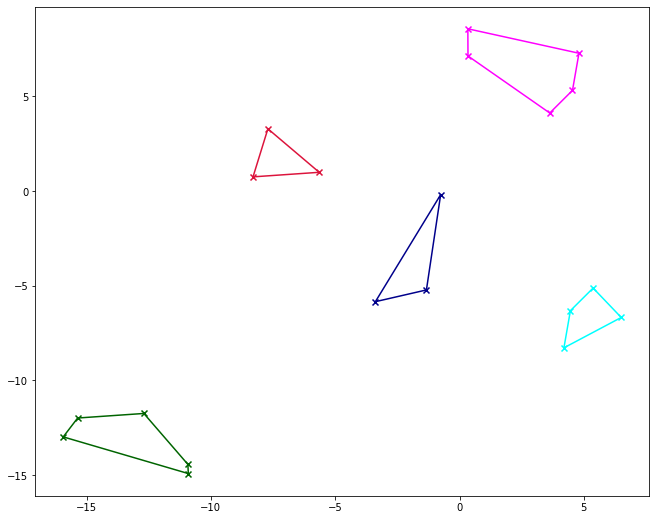

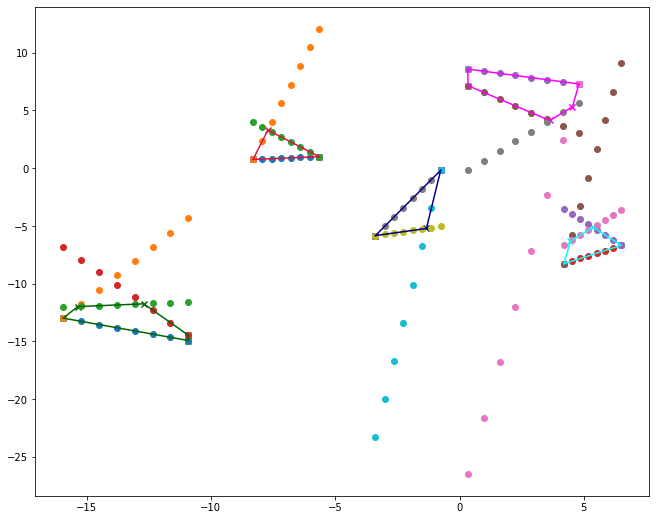

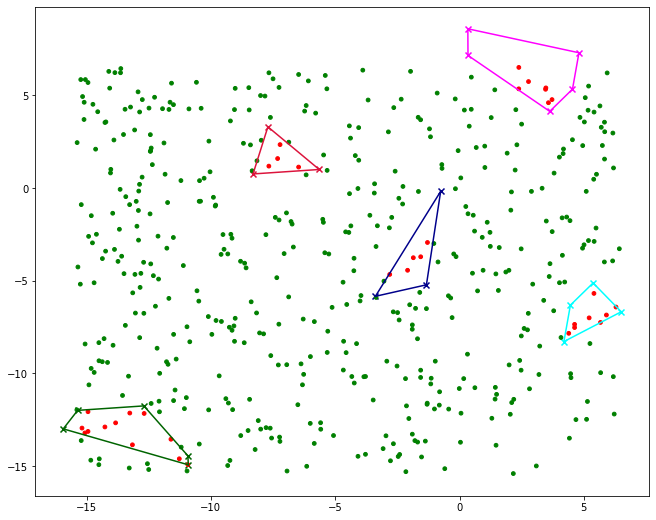

In [3]:
inequat = Inequations(N = 5)
cons = inequat()

In [4]:
cons([-2, -5])

0.8746901966350293

### Testing how the minimize function works with constraints - it gives not the restriced point

In [8]:
fun = lambda x: (x[0] - 5)** 2 + (x[1] - 5)**2
#bnds = ((-20, 40), (-40, 30))
bnds = Bounds((-20, -30), (30, 30), keep_feasible=True)
constraints = ({'type': 'ineq', 'fun': cons})
#for f in cons:
#    constraints.append({'type': 'ineq', 'fun': f})
#cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2 * x[1] + 2},
#        {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},
#        {'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})

res = minimize(fun, (3, 4), method='SLSQP', bounds=bnds, constraints=constraints, options = {'eps': 1e-9})

print(res)

     fun: 0.31233863126724043
     jac: array([-0.91570682,  0.64096484])
 message: 'Optimization terminated successfully'
    nfev: 245
     nit: 41
    njev: 41
  status: 0
 success: True
       x: array([4.54214799, 5.32048428])


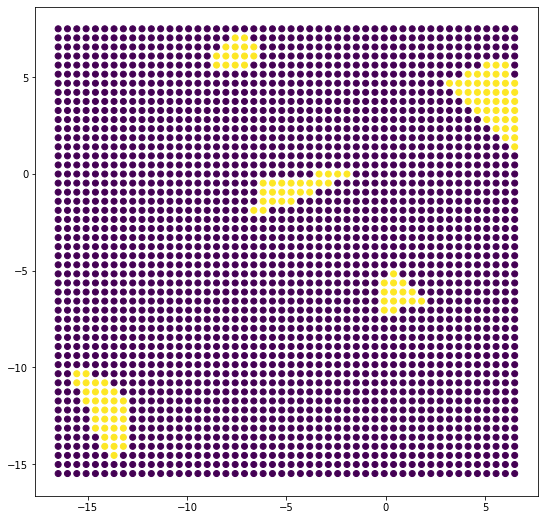

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (9, 9))
x = np.linspace(-16.5, 6.5, 50)
y = np.linspace(-15.5, 7.5, 50)

def color(val):
    if val <= 0:
        return 3 #'green'
    else:
        return 5 #'red'
    
colormap_f = np.zeros((x.shape[0], y.shape[0]))
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        colormap_f[i, j] = color(cons([x[i], y[j]]))
        
ax.scatter(np.meshgrid(x, y)[0], np.meshgrid(x, y)[1], c = colormap_f)